In [ ]:
pip install pycuda

In [2]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy
import time
import math

In [3]:
import numpy
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# numpy.random.seed(1)

In [4]:
def formatting(a): #needed only once

    try:
        (f_h,f_w,ch,filters) = a.shape
        b = numpy.zeros((filters,ch,f_h,f_w))
        x = len(a[0][0][0])
        for i in range(len(a)):
            for j in range(len(a[0])):
                for k in range(len(a[0][0])):
                    for l in range(len(a[0][0][0])):
                        b[l][k][i][j] = a[i][j][k][l]

    except:
        (height,width,channel) = a.shape
        b = numpy.zeros((channel,height,width))
        for i in range(len(a)):
            for j in range(len(a[0])):
                for k in range(len(a[0][0])):
                    b[k][i][j] = a[i][j][k]
    return b

In [5]:
def weight_transpose_formatting(a):
    (f_h,f_w,filters,ch) = a.shape
    b = numpy.zeros((filters,ch,f_h,f_w))
    x = len(a[0][0][0])
    for i in range(len(a)):
        for j in range(len(a[0])):
            for k in range(len(a[0][0])):
                for l in range(len(a[0][0][0])):
                    b[k][l][i][j] = a[i][j][k][l]
    return b

In [6]:
def deformatting(X): #needed only once
    (ch,height,width) = X.shape
    Y = numpy.zeros((height,width,ch))
    for i in range(len(X[0])):
        for j in range(len(X[0][0])):
            for k in range(len(X)):
                Y[i][j][k] = X[k][i][j]
    return Y

In [7]:
def relu_exp(a):
    for dim1 in range(a.shape[0]):
        for dim2 in range(a.shape[1]):
            if(a[dim1][dim2]<0.0):
                a[dim1][dim2] = 0.0
    return a

In [8]:
import cv2
img = numpy.resize(cv2.imread('/content/1.jpg')/255.,(400,288,3))
#print(img)
img = formatting(img)
print(img.shape)

(3, 400, 288)


In [9]:
def kernel_for_sum(arr1,arr2):

    h = numpy.int32(len(arr1))
    w = numpy.int32(len(arr1[0]))

    grid_h = math.ceil(h/32)
    grid_w = math.ceil(w/32)

    arr1_d = cuda.mem_alloc(arr1.nbytes)
    arr2_d = cuda.mem_alloc(arr2.nbytes)

    cuda.memcpy_htod(arr1_d,arr1)
    cuda.memcpy_htod(arr2_d,arr2)

    mod = SourceModule("""
    __global__ void Sum_of_arrays(float *arr1_d, float *arr2_d, int w) {
            int row = blockIdx.y*blockDim.y + threadIdx.y;
            int col = blockIdx.x*blockDim.y + threadIdx.x;

            arr1_d[row*w + col] = arr1_d[row*w + col] + arr2_d[row*w + col];
        }
    """)

    Sum_of_arrays = mod.get_function("Sum_of_arrays")
    Sum_of_arrays(arr1_d,arr2_d,w,block=(32,32,1),grid=(grid_w,grid_h,1))

    cuda.memcpy_dtoh(arr1,arr1_d)
    return arr1

In [10]:
def convolution_single_step_volume(tempinput, tempfilter, tempoutput, bais):

    mod = SourceModule("""
__global__ void convolution_2d_volume(float *inumpyut, float *filter, float *output, int height, int width, int channels){
    int FILTER_DIM = 3;
    int FILTER_OFFSET = FILTER_DIM/2 ;

    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    int start_r = row - FILTER_OFFSET;
    int start_c = col - FILTER_OFFSET;

    float temp = 0;
    int no_of_pixels = height*width;
    if((row<height)&&(col<width)){
        for (int k = 0; k < channels; k++){
            for (int i = 0; i < FILTER_DIM; i++){
                for (int j = 0; j < FILTER_DIM; j++){
                    if ((start_r + i) >= 0 && (start_r + i) < height){
                        if ((start_c + j) >= 0 && (start_c + j) < width){
                            temp += inumpyut[k*no_of_pixels + (start_r + i) * width + (start_c + j)] * filter[k*FILTER_DIM*FILTER_DIM + i * FILTER_DIM + j];
                        }
                    }
                }
            }
        }
        output[row * width + col] = temp;
    }

    
}
""")
    (ch, h, w) = tempinput.shape
    height = numpy.int32(h)
    width = numpy.int32(w)
    channels = numpy.int32(ch)
    
    gridHeight = math.ceil(h/32)
    gridWidth = math.ceil(w/32)

    #start = time.time()
    conv = mod.get_function("convolution_2d_volume")

    #diff = 0

    tempinput = tempinput.astype(numpy.float32)
    tempfilter = tempfilter.astype(numpy.float32)
    tempoutput = tempoutput.astype(numpy.float32)

    tempinputD = cuda.mem_alloc(tempinput.nbytes)
    tempfilterD = cuda.mem_alloc(tempfilter.nbytes)
    tempoutputD = cuda.mem_alloc(tempoutput.nbytes)

    cuda.memcpy_htod(tempinputD, tempinput)
    cuda.memcpy_htod(tempfilterD, tempfilter)
    cuda.memcpy_htod(tempoutputD, tempoutput)

    #startker = time.time()
    conv(tempinputD, tempfilterD, tempoutputD, height, width, channels, block=(32,32,1), grid=(gridWidth,gridHeight,1))  # block format is important! (width,height,1)
    #endker = time.time()

    #differencekernel = endker-startker
    #diff += differencekernel

    cuda.memcpy_dtoh(tempoutput, tempoutputD)

    #end = time.time()
    tempoutput = tempoutput + (bais*channels) #only bais?
    tempoutput = relu_exp(tempoutput)
    return tempoutput


In [11]:
def convolution_layer(X,W,b):
    (channels, height_X, width_X) = X.shape
    
    (filters, channels, height_W, width_W) = W.shape
    O = numpy.zeros((height_X,width_X))
    final_output = []
    for f in range(filters):
        one_filter_output = convolution_single_step_volume(X,W[f],O,b[f])
        final_output.append(one_filter_output)
    
    return numpy.array(final_output)

In [12]:
def Max_Pool_Single_Step(tempinput,tempoutput,h,w):

    widthO = w/2
    heightO = h/2
    widthO = numpy.int32(widthO)
    heightO = numpy.int32(heightO)
    mod = SourceModule("""
    __global__ void maxpool(float *input, float *output, int inputDimX, int inputDimY, int outputDimX, int outputDimY){

        int row = blockIdx.y * blockDim.y + threadIdx.y;
        int col = blockIdx.x * blockDim.x + threadIdx.x;

        if((row<outputDimY)&&(col<outputDimX)){
            float temp[4];
            temp[0] = input[(2*row) * inputDimX + (2*col)];
            temp[1] = input[(2*row) * inputDimX + (2*col+1)]; 
            temp[2] = input[(2*row+1) * inputDimX + (2*col)]; 
            temp[3] = input[(2*row+1) * inputDimX + (2*col+1)];

            int i;
            float max = 0;
            for(i=0; i<4; i++){
                if(temp[i]>max){
                    max = temp[i];
                }
            }
            output[row * outputDimX + col] = max;
        }
    }
    """)
    height = numpy.int32(h)
    width = numpy.int32(w)
    
    gridHeight = math.ceil(h/64)
    gridWidth = math.ceil(w/64)

    diff = 0

    start = time.time()
    Mpool = mod.get_function("maxpool")


    tempinput = tempinput.astype(numpy.float32)
    tempoutput = tempoutput.astype(numpy.float32)

    tempinputD = cuda.mem_alloc(tempinput.nbytes)
    tempoutputD = cuda.mem_alloc(tempoutput.nbytes)

    cuda.memcpy_htod(tempinputD, tempinput)
    cuda.memcpy_htod(tempoutputD, tempoutput)

    startker = time.time()
    Mpool(tempinputD, tempoutputD, width, height, widthO, heightO, block=(32,32,1), grid=(gridWidth,gridHeight,1))  # block format is important! (width,height,1)
    endker = time.time()
    
    differencekernel = endker-startker
    diff += differencekernel

    cuda.memcpy_dtoh(tempoutput, tempoutputD)
    return tempoutput

In [13]:
def Max_pool_layer(X):
    (channels,h,w) = X.shape
    widthO = w/2
    heightO = h/2
    widthO = numpy.int32(widthO)
    heightO = numpy.int32(heightO)
    final_output = []
    for c in range(channels):
        output = numpy.zeros(shape=(heightO,widthO)).astype(numpy.float32)
        one_channel_output = Max_Pool_Single_Step(X[c],output,h,w)
        final_output.append(one_channel_output)
    return numpy.array(final_output)

In [14]:
def conv2DTranspose(tempinput, tempfilter, tempoutput, h, w):
    mod = SourceModule("""
    __global__ void convTranspose(float *input, float *filter, float *output, int inputDimX, int inputDimY, int outputDimX){

    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    int i, j;
    for(i = 0; i < 2; i++){
        for(j = 0; j < 2; j++){
            if((row<inputDimY)&&(col<inputDimX)){
                output[(2*row + i) * outputDimX + (2*col + j)] = input[row * inputDimX + col] * filter[2*i + j];
            }
        }
    }
    //output[(2*row) * outputDimX + (2*col)] = temp[0];
    //output[(2*row) * outputDimX + (2*col+1)] = temp[1];
    //output[(2*row+1) * outputDimX + (2*col)] = temp[2];
    //output[(2*row+1) * outputDimX + (2*col+1)] = temp[3];

    }
    # """)
    gridHeight = math.ceil(h/32)
    gridWidth = math.ceil(w/32)

    wo = 2*w

    height = numpy.int32(h)
    width = numpy.int32(w)

    widthO = numpy.int32(wo)

    #diff = 0

    #start = time.time()
    convtrans = mod.get_function("convTranspose")

    tempinput = tempinput.astype(numpy.float32)
    tempfilter = tempfilter.astype(numpy.float32)
    tempoutput = tempoutput.astype(numpy.float32)

    tempinputD = cuda.mem_alloc(tempinput.nbytes)
    tempfilterD = cuda.mem_alloc(tempfilter.nbytes)
    tempoutputD = cuda.mem_alloc(tempoutput.nbytes)

    cuda.memcpy_htod(tempinputD, tempinput)
    cuda.memcpy_htod(tempfilterD, tempfilter)
    cuda.memcpy_htod(tempoutputD, tempoutput)

    startker = time.time()
    convtrans(tempinputD, tempfilterD, tempoutputD, width, height, widthO, block=(32,32,1), grid=(gridWidth,gridHeight,1))  # block format is important! (width,height,1)
    endker = time.time()
    
    #differencekernel = endker-startker
    #diff += differencekernel

    cuda.memcpy_dtoh(tempoutput, tempoutputD)

    #end = time.time()

    return tempoutput


In [15]:
def Conv2DTranspose_layer(X, W, b):
    # global total_ch
    # global total_soa
    (n_c_prev,height,width) = X.shape
    (filters,n_c_prev,f,f) = W.shape
    final_output = []
    for f in range(filters):
        base_array = numpy.zeros(shape=(height*2,width*2)).astype(numpy.float32)  #initializing with zero
        final_output.append([])
        for c in range(n_c_prev):
            # start = time.time()
            tempoutput = numpy.zeros(shape=(height*2,width*2))
            one_channel_output =  conv2DTranspose(X[c], W[f][c], tempoutput, height, width)
            # print("input",X[c])
            # print("filter",W[f][c])
            # print("output",one_channel_output)
            # end = time.time()
            # total_ch+=(end-start)
            #print(np.array(one_channel_output).shape)
            # start = time.time()
            # one_kernel_output = sum_of_arrays(base_array,one_channel_output)
            one_kernel_output = kernel_for_sum(base_array,one_channel_output)
            #print("channel output", one_kernel_output)
            # end = time.time()
            #print("Time for one iteration:",end-start)
            # total_soa+=(end-start)
            #print(np.array(one_kernel_output).shape)
            base_array = one_kernel_output
        one_kernel_output = one_kernel_output + (b[f]*n_c_prev)
        one_kernel_output = relu_exp(one_kernel_output)
        final_output[-1] = one_kernel_output
    return numpy.array(final_output)

In [16]:
def concat(X,X_prev):
    (channels,height,width) = X_prev.shape
    output = []
    for ch in range(channels):
        output.append(X[ch])
    for ch in range(channels):
        output.append(X_prev[ch])
    return numpy.array(output)

## Preprocessing of Weights

In [17]:
weights = h5py.File('/content/drive/MyDrive/w.hdf5', 'r')
W_11 = weights['model_weights']['conv2d_1']['conv2d_1']['kernel:0'][:]
W_11 = formatting(W_11)
b_11 = weights['model_weights']['conv2d_1']['conv2d_1']['bias:0'][:] #(32,)
W_12 = weights['model_weights']['conv2d_2']['conv2d_2']['kernel:0'][:]
W_12 = formatting(W_12)
b_12 = weights['model_weights']['conv2d_2']['conv2d_2']['bias:0'][:]

W_21 = weights['model_weights']['conv2d_3']['conv2d_3']['kernel:0'][:]
W_21 = formatting(W_21)
b_21 = weights['model_weights']['conv2d_3']['conv2d_3']['bias:0'][:]
W_22 = weights['model_weights']['conv2d_4']['conv2d_4']['kernel:0'][:]
W_22 = formatting(W_22)
b_22 = weights['model_weights']['conv2d_4']['conv2d_4']['bias:0'][:]

W_31 = weights['model_weights']['conv2d_5']['conv2d_5']['kernel:0'][:]
W_31 = formatting(W_31)
b_31 = weights['model_weights']['conv2d_5']['conv2d_5']['bias:0'][:]
W_32 = weights['model_weights']['conv2d_6']['conv2d_6']['kernel:0'][:]
W_32 = formatting(W_32)
b_32 = weights['model_weights']['conv2d_6']['conv2d_6']['bias:0'][:]

W_41 = weights['model_weights']['conv2d_7']['conv2d_7']['kernel:0'][:]
W_41 = formatting(W_41)
b_41 = weights['model_weights']['conv2d_7']['conv2d_7']['bias:0'][:]
W_42 = weights['model_weights']['conv2d_8']['conv2d_8']['kernel:0'][:]
W_42 = formatting(W_42)
b_42 = weights['model_weights']['conv2d_8']['conv2d_8']['bias:0'][:]

W_51 = weights['model_weights']['conv2d_9']['conv2d_9']['kernel:0'][:]
W_51 = formatting(W_51)
b_51 = weights['model_weights']['conv2d_9']['conv2d_9']['bias:0'][:]
W_52 = weights['model_weights']['conv2d_10']['conv2d_10']['kernel:0'][:]
W_52 = formatting(W_52)
b_52 = weights['model_weights']['conv2d_10']['conv2d_10']['bias:0'][:]

W_61 = weights['model_weights']['conv2d_transpose_1']['conv2d_transpose_1']['kernel:0'][:]
W_61 = weight_transpose_formatting(W_61)
b_61 = weights['model_weights']['conv2d_transpose_1']['conv2d_transpose_1']['bias:0'][:]

W_62 = weights['model_weights']['conv2d_11']['conv2d_11']['kernel:0'][:]
W_62 = formatting(W_62)
b_62 = weights['model_weights']['conv2d_11']['conv2d_11']['bias:0'][:]
W_63 = weights['model_weights']['conv2d_12']['conv2d_12']['kernel:0'][:]
W_63 = formatting(W_63)
b_63 = weights['model_weights']['conv2d_12']['conv2d_12']['bias:0'][:]

W_71 = weights['model_weights']['conv2d_transpose_2']['conv2d_transpose_2']['kernel:0'][:]
W_71 = weight_transpose_formatting(W_71)
b_71 = weights['model_weights']['conv2d_transpose_2']['conv2d_transpose_2']['bias:0'][:]


W_72 = weights['model_weights']['conv2d_13']['conv2d_13']['kernel:0'][:]
W_72 = formatting(W_72)
b_72 = weights['model_weights']['conv2d_13']['conv2d_13']['bias:0'][:]
W_73 = weights['model_weights']['conv2d_14']['conv2d_14']['kernel:0'][:]
W_73 = formatting(W_73)
b_73 = weights['model_weights']['conv2d_14']['conv2d_14']['bias:0'][:]

W_81 = weights['model_weights']['conv2d_transpose_3']['conv2d_transpose_3']['kernel:0'][:]
W_81 = weight_transpose_formatting(W_81)
b_81 = weights['model_weights']['conv2d_transpose_3']['conv2d_transpose_3']['bias:0'][:]


W_82 = weights['model_weights']['conv2d_15']['conv2d_15']['kernel:0'][:]
W_82 = formatting(W_82)
b_82 = weights['model_weights']['conv2d_15']['conv2d_15']['bias:0'][:]
W_83 = weights['model_weights']['conv2d_16']['conv2d_16']['kernel:0'][:]
W_83 = formatting(W_83)
b_83 = weights['model_weights']['conv2d_16']['conv2d_16']['bias:0'][:]

W_91 = weights['model_weights']['conv2d_transpose_4']['conv2d_transpose_4']['kernel:0'][:]
W_91 = weight_transpose_formatting(W_91)
b_91 = weights['model_weights']['conv2d_transpose_4']['conv2d_transpose_4']['bias:0'][:]


W_92 = weights['model_weights']['conv2d_17']['conv2d_17']['kernel:0'][:]
W_92 = formatting(W_92)
b_92 = weights['model_weights']['conv2d_17']['conv2d_17']['bias:0'][:]
W_93 = weights['model_weights']['conv2d_18']['conv2d_18']['kernel:0'][:]
W_93 = formatting(W_93)
b_93 = weights['model_weights']['conv2d_18']['conv2d_18']['bias:0'][:]

W_out = weights['model_weights']['conv2d_19']['conv2d_19']['kernel:0'][:]
W_out = formatting(W_out)
b_out = weights['model_weights']['conv2d_19']['conv2d_19']['bias:0'][:]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Z_1 = convolution_layer(img, W_11, b_11)
print(Z_1.shape)

Z_1 = convolution_layer(Z_1, W_12, b_12)
print(Z_1.shape)

A_1 = Max_pool_layer(Z_1)
print( A_1.shape)

In [ ]:

Z_2 = convolution_layer(A_1, W_21, b_21)
print(Z_2.shape)


Z_2 = convolution_layer(Z_2, W_22, b_22)
print(Z_2.shape)

A_2 = Max_pool_layer(Z_2)
print( A_2.shape)

(64, 200, 144)
(64, 200, 144)
(64, 100, 72)


In [ ]:

Z_3 = convolution_layer(A_2, W_31, b_31)
print(Z_3.shape)


Z_3 = convolution_layer(Z_3, W_32, b_32)
print(Z_3.shape)

# hparameters = {"stride" : 2, "f": 2}
A_3 = Max_pool_layer(Z_3)
print( A_3.shape)

(128, 100, 72)
(128, 100, 72)
(128, 50, 36)


In [ ]:

Z_4 = convolution_layer(A_3, W_41, b_41)
print(Z_4.shape)

Z_4 = convolution_layer(Z_4, W_42, b_42)
print(Z_4.shape)

# hparameters = {"stride" : 2, "f": 2}
A_4 = Max_pool_layer(Z_4)
print( A_4.shape)

(256, 50, 36)
(256, 50, 36)
(256, 25, 18)


In [ ]:
Z_5 = convolution_layer(A_4, W_51, b_51)
print(Z_5.shape)

Z_5 = convolution_layer(Z_5, W_52, b_52)
print(Z_5.shape)

(512, 25, 18)
(512, 25, 18)


In [ ]:
Z_6T = Conv2DTranspose_layer(Z_5, W_61, b_61)
print(Z_6T.shape)

Z_61 = concat(Z_6T,Z_4)
print(Z_61.shape)

Z_6 = convolution_layer(Z_61, W_62, b_62)
print(Z_6.shape)

Z_6 = convolution_layer(Z_6, W_63, b_63)
print(Z_6.shape)


(256, 50, 36)
(512, 50, 36)
(256, 50, 36)
(256, 50, 36)


In [ ]:
Z_7T = Conv2DTranspose_layer(Z_6, W_71, b_71)
print(Z_7T.shape)

Z_71 = concat(Z_7T,Z_3)
print(Z_71.shape)

Z_7 = convolution_layer(Z_71, W_72, b_72)
print(Z_7.shape)

Z_7 = convolution_layer(Z_7, W_73, b_73)
print(Z_7.shape)

In [19]:
Z_8T = Conv2DTranspose_layer(Z_7, W_81, b_81)
print(Z_8T.shape)

Z_81 = concat(Z_8T,Z_2)
print(Z_81.shape)

Z_8 = convolution_layer(Z_81, W_82, b_82)
print(Z_8.shape)

Z_8 = convolution_layer(Z_8, W_83, b_83)
print(Z_8.shape)

(64, 200, 144)
(128, 200, 144)
(64, 200, 144)
(64, 200, 144)


In [26]:
Z_9T = Conv2DTranspose_layer(Z_8, W_91, b_91)
print(Z_9T.shape)

Z_91 = concat(Z_9T,Z_1)
print(Z_91.shape)

Z_9 = convolution_layer(Z_91, W_92, b_92)
print(Z_9.shape)

Z_9 = convolution_layer(Z_9, W_93, b_93)
print(Z_9.shape)

(32, 400, 288)
(64, 400, 288)
(32, 400, 288)
(32, 400, 288)


In [ ]:
Z_out = convolution_layer(Z_9, W_out, b_out)
Z_out = deformatting(Z_out)
print(Z_out.shape)

In [ ]:
print(Z_out)
# Z_out_1 = Z_out*255, use if required

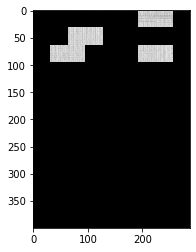

In [24]:
plt.imshow(Z_out[:,:,0])